In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
DATASET_PATH = "./data"
train_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True)
DATA_MEANS = (train_dataset.data / 255.0).mean(axis=(0,1,2))
DATA_STD = (train_dataset.data / 255.0).std(axis=(0,1,2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = (img / 255. - DATA_MEANS) / DATA_STD
    return img

# We need to stack the batch elements
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)
test_transform = image_to_numpy
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      image_to_numpy
                                     ])
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)

_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))

2023-08-02 12:36:49.289376: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 12:36:50.557650: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Files already downloaded and verified
Data mean [0.49139968 0.48215841 0.44653091]
Data std [0.24703223 0.24348513 0.26158784]
Files already downloaded and verified


### This script requires the predictions files (currently not on github due to larger size)

In [2]:
val_loader   = data.DataLoader(val_set,
                               batch_size=256,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate,
                               num_workers=4,
                               persistent_workers=True)
gt = []
for x in val_loader:
    gt.append(x[1])
gt = np.concatenate(gt,axis = 0)

In [3]:
baseline = pd.read_csv('baseline.csv').to_numpy().reshape((5000,))
np.mean(baseline==gt)


0.919

In [4]:
frames_5 = {} 
for i in range(15):
    frames_5[i] = pd.read_csv(f'./predictions/resnet_0.5_{i}_set.csv').to_numpy()
frames_6 = {} 
for i in range(15):
    frames_6[i] = pd.read_csv(f'./predictions/resnet_0.6_{i}_set.csv').to_numpy()
frames_7 = {} 
for i in range(15):
    frames_7[i] = pd.read_csv(f'./predictions/resnet_0.7_{i}_set.csv').to_numpy()
frames_8 = {} 
for i in range(15):
    frames_8[i] = pd.read_csv(f'./predictions/resnet_0.8_{i}_set.csv').to_numpy()
frames_9 = {} 
for i in range(15):
    frames_9[i] = pd.read_csv(f'./predictions/resnet_0.9_{i}_set.csv').to_numpy()


In [5]:
seed_dis = np.zeros((5,15,10))
for i in range(15):
    for j in range(10):
        pos = np.where(baseline == j)
        seed_dis[0,i,j] = np.mean(frames_5[i][:,-1][pos] != j)
for i in range(15):
    for j in range(10):
        pos = np.where(baseline == j)
        seed_dis[1,i,j] = np.mean(frames_6[i][:,-1][pos] != j)
for i in range(15):
    for j in range(10):
        pos = np.where(baseline == j)
        seed_dis[2,i,j] = np.mean(frames_7[i][:,-1][pos] != j)
for i in range(15):
    for j in range(10):
        pos = np.where(baseline == j)
        seed_dis[3,i,j] = np.mean(frames_8[i][:,-1][pos] != j)
for i in range(15):
    for j in range(10):
        pos = np.where(baseline == j)
        seed_dis[4,i,j] = np.mean(frames_9[i][:,-1][pos] != j)

In [15]:
print(np.std(seed_dis,axis = 0), '\n',np.mean(seed_dis ,axis = 0))

[0.01441798 0.01302317 0.01546248 0.03755056 0.02297229 0.02122889
 0.01301567 0.02530224 0.00978728 0.01321069] 
 [0.12053743 0.03868809 0.15954631 0.25625823 0.1047619  0.18493248
 0.04852234 0.10595691 0.04928717 0.05990903]


In [6]:
from scipy.stats import spearmanr as spr
from sklearn import preprocessing as p
# !pip install sklearn
mms = p.MinMaxScaler()


In [7]:
sprmat = np.zeros((5,15,15))
for k in range(5):
    for i in range(15):
        for j in range(15):
            x1 = mms.fit_transform(seed_dis[k,i,:].reshape(-1,1)).reshape(-2,)
            x2 = mms.fit_transform(seed_dis[k,j,:].reshape(-1,1)).reshape(-2,)
            sprmat[k,i,j] = spr(x1,x2)[0]

<Axes: title={'center': 'Rank correlation 50% sparsity'}>

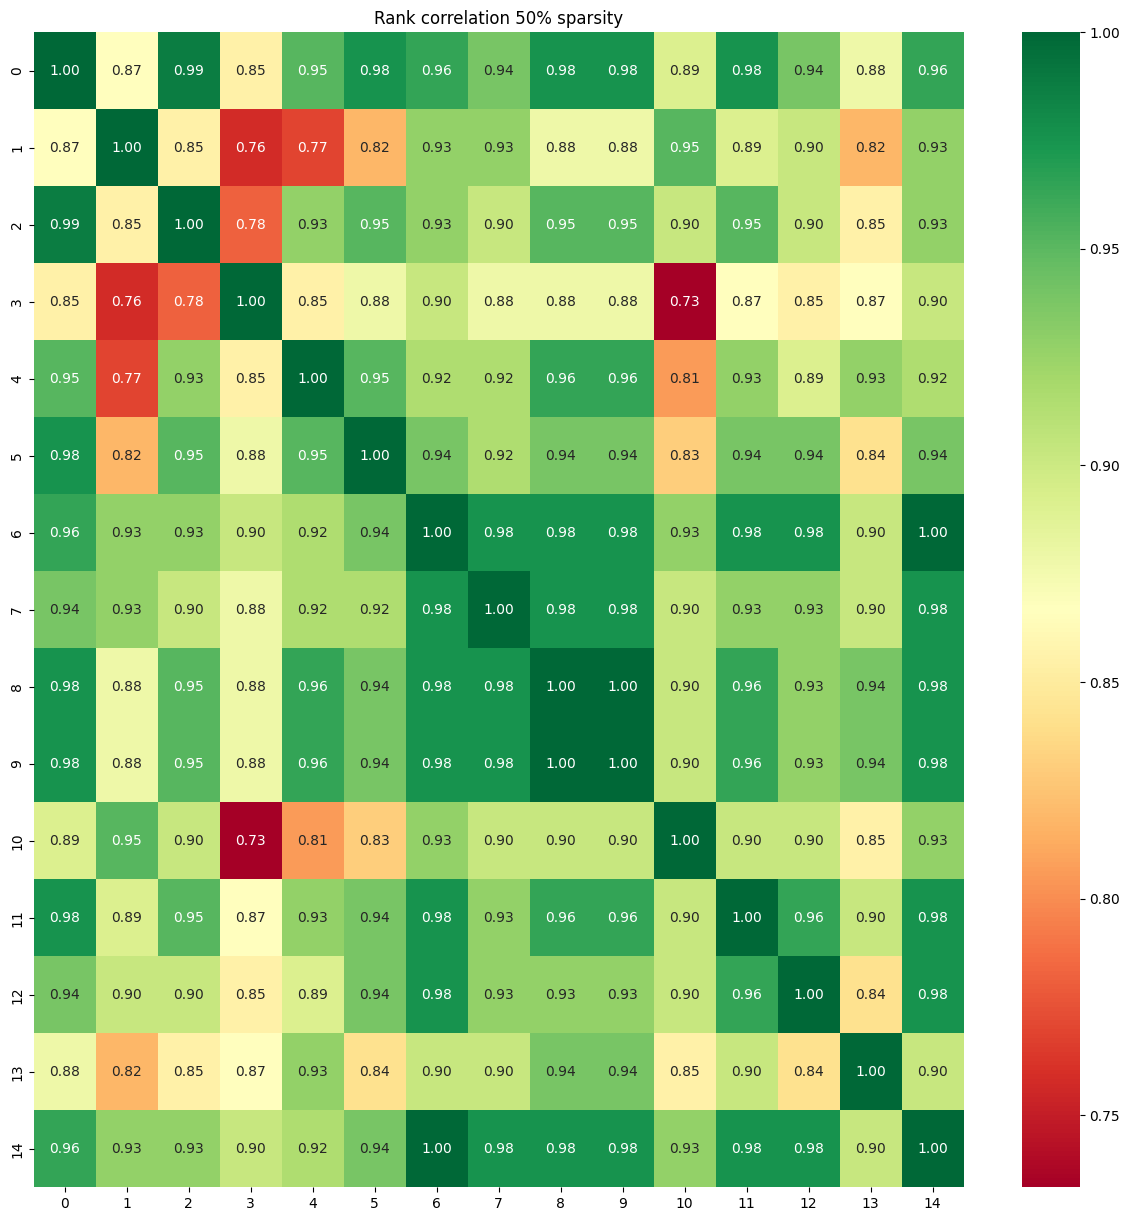

In [9]:
a4_dims = (15, 15)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title('Rank correlation 50% sparsity')
sns.heatmap(sprmat[0], annot=True, fmt='.2f', cmap='RdYlGn',ax = ax)

<Axes: title={'center': 'Rank correlation 60% sparsity'}>

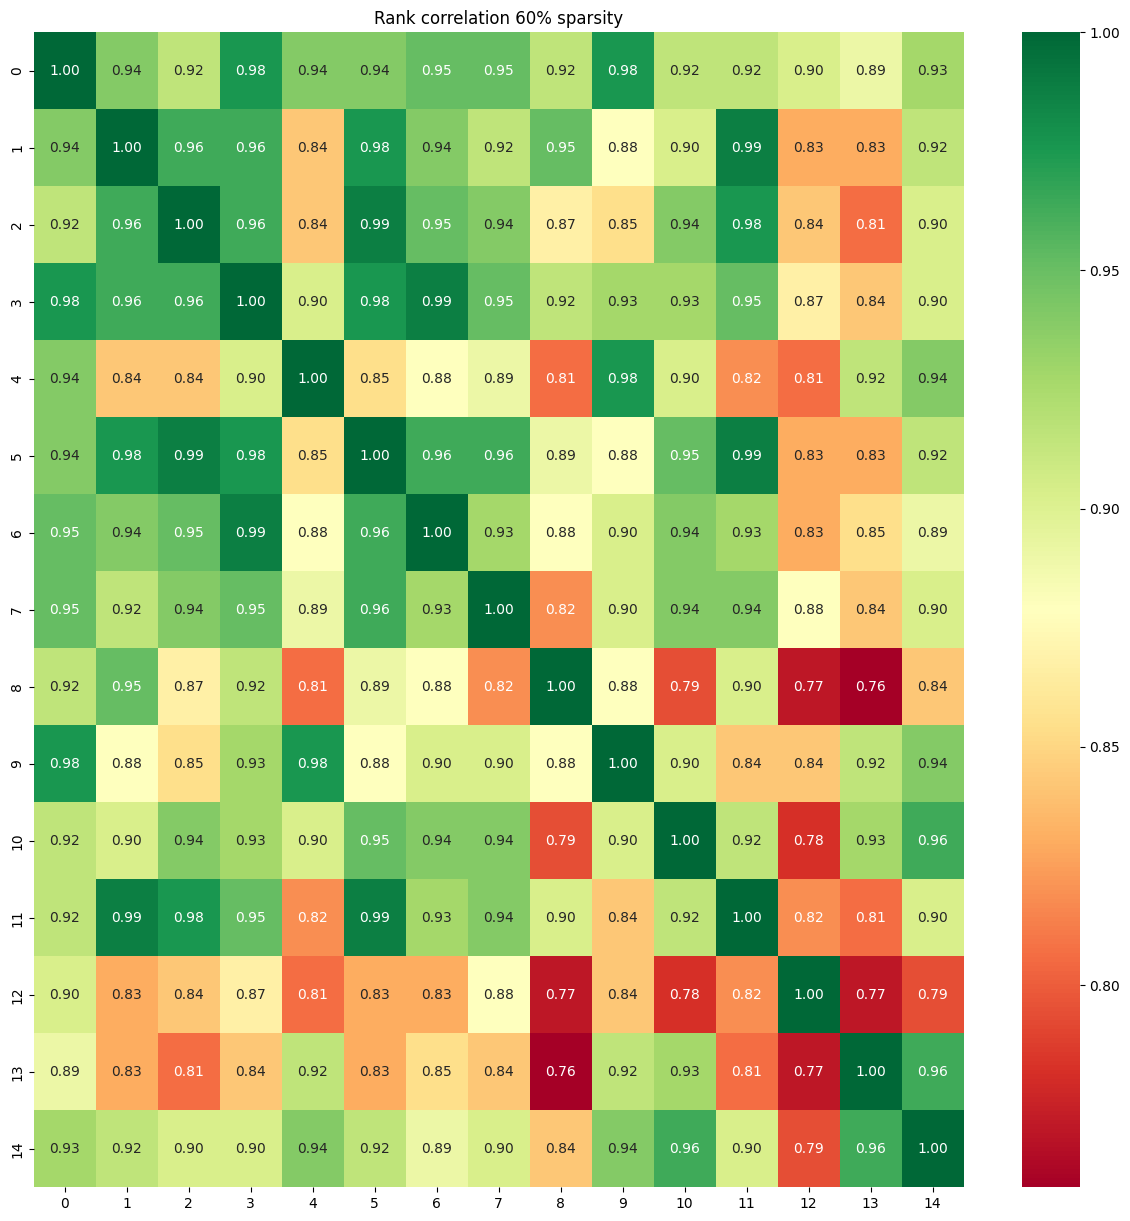

In [10]:
a4_dims = (15, 15)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title('Rank correlation 60% sparsity')
sns.heatmap(sprmat[1], annot=True, fmt='.2f', cmap='RdYlGn',ax = ax)

<Axes: title={'center': 'Rank correlation 70% sparsity'}>

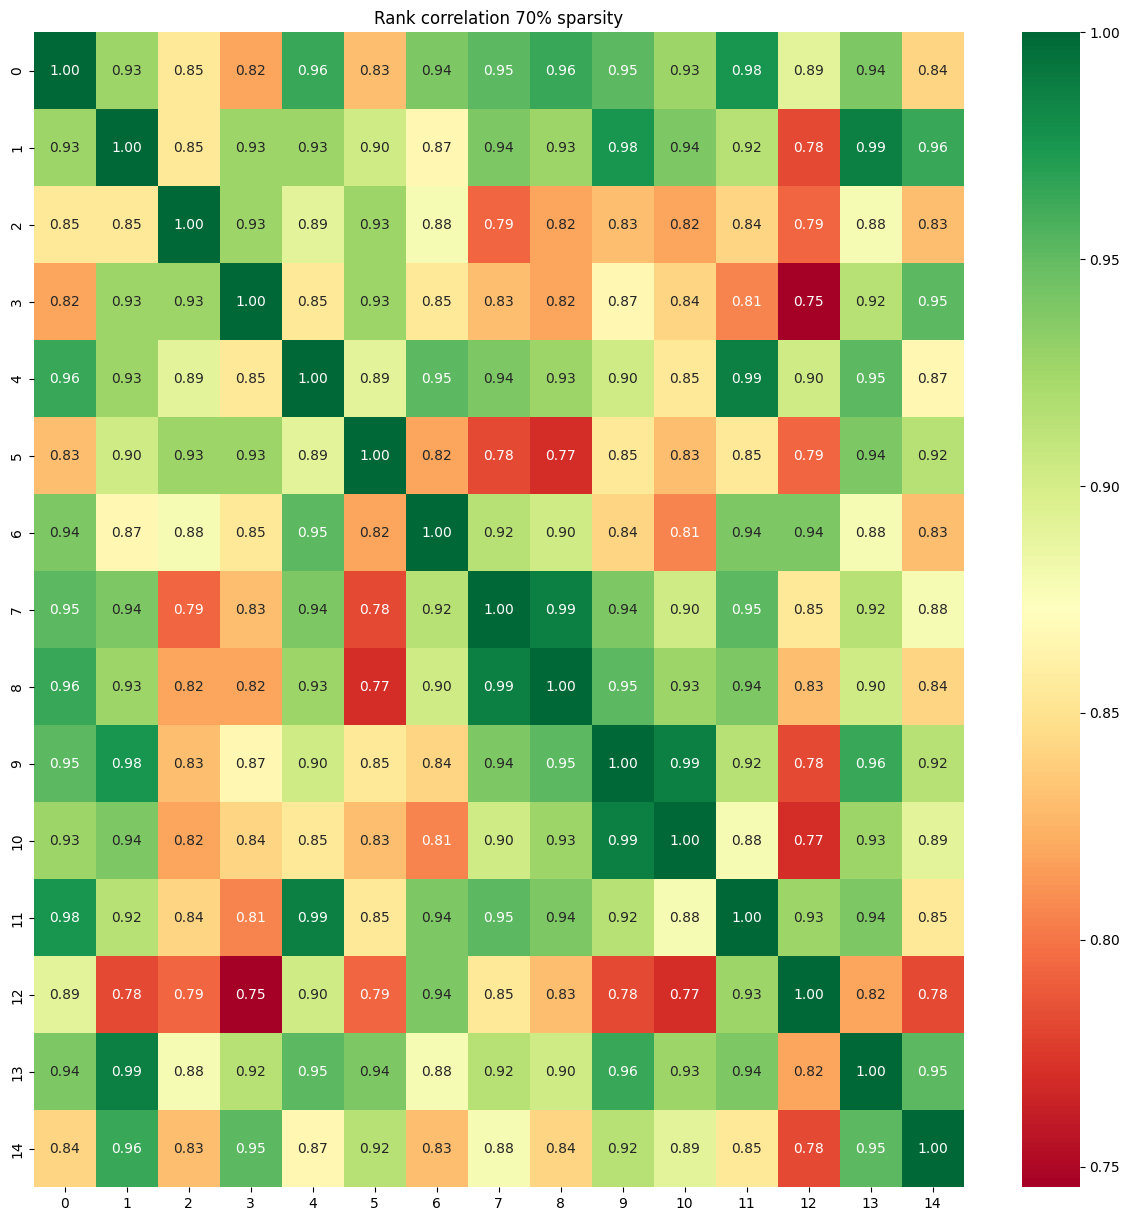

In [12]:
a4_dims = (15, 15)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title('Rank correlation 70% sparsity')
sns.heatmap(sprmat[2], annot=True, fmt='.2f', cmap='RdYlGn',ax = ax)

<Axes: title={'center': 'Rank correlation 80% sparsity'}>

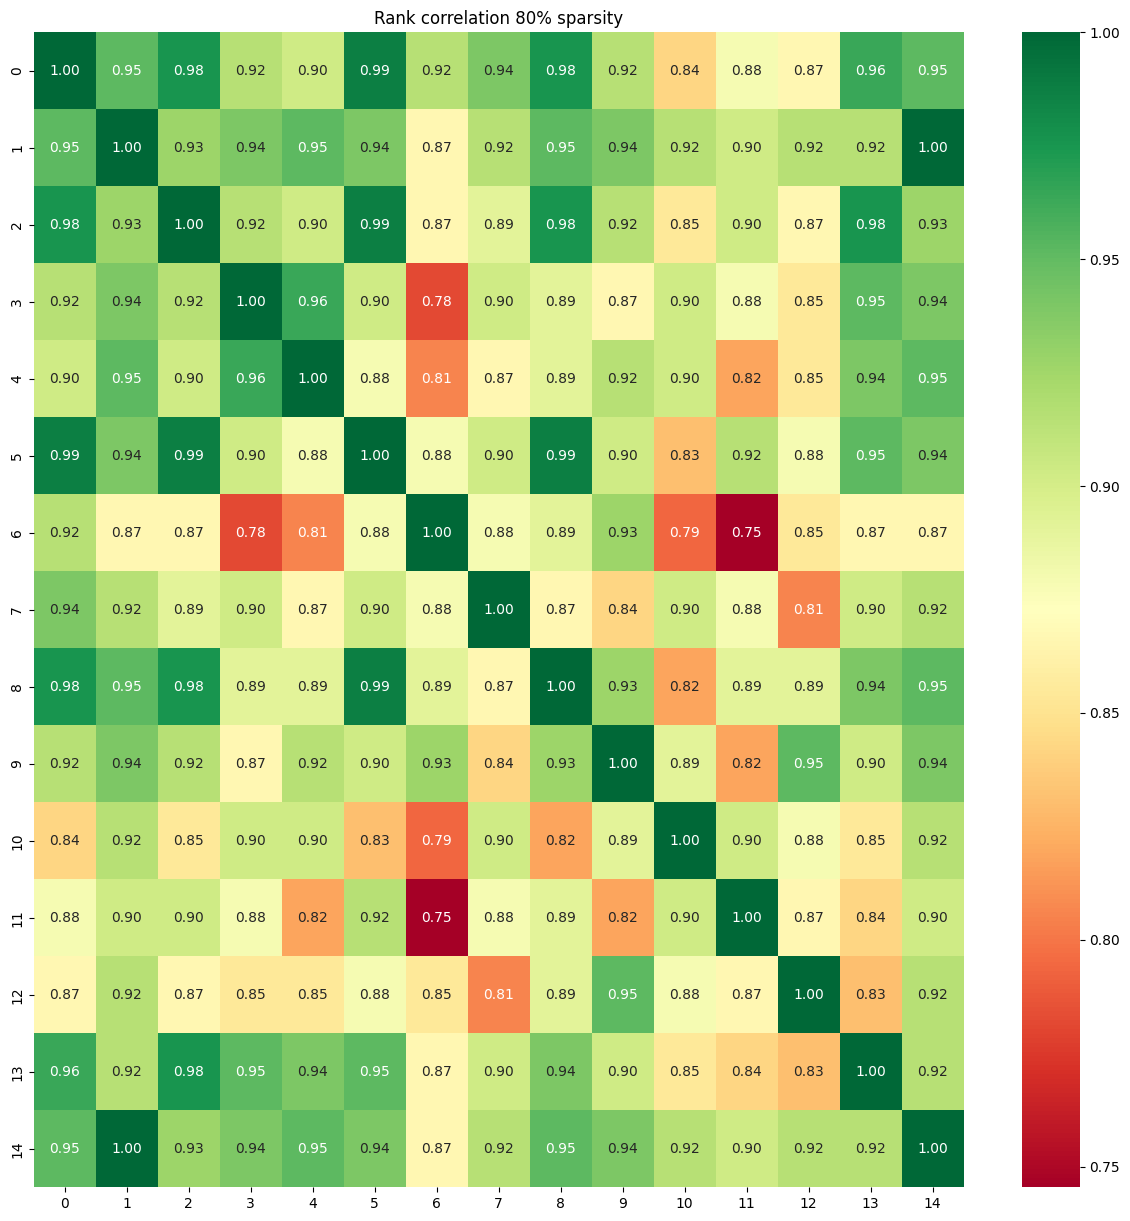

In [13]:
a4_dims = (15, 15)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title('Rank correlation 80% sparsity')
sns.heatmap(sprmat[3], annot=True, fmt='.2f', cmap='RdYlGn',ax = ax)

<Axes: title={'center': 'Rank correlation 90% sparsity'}>

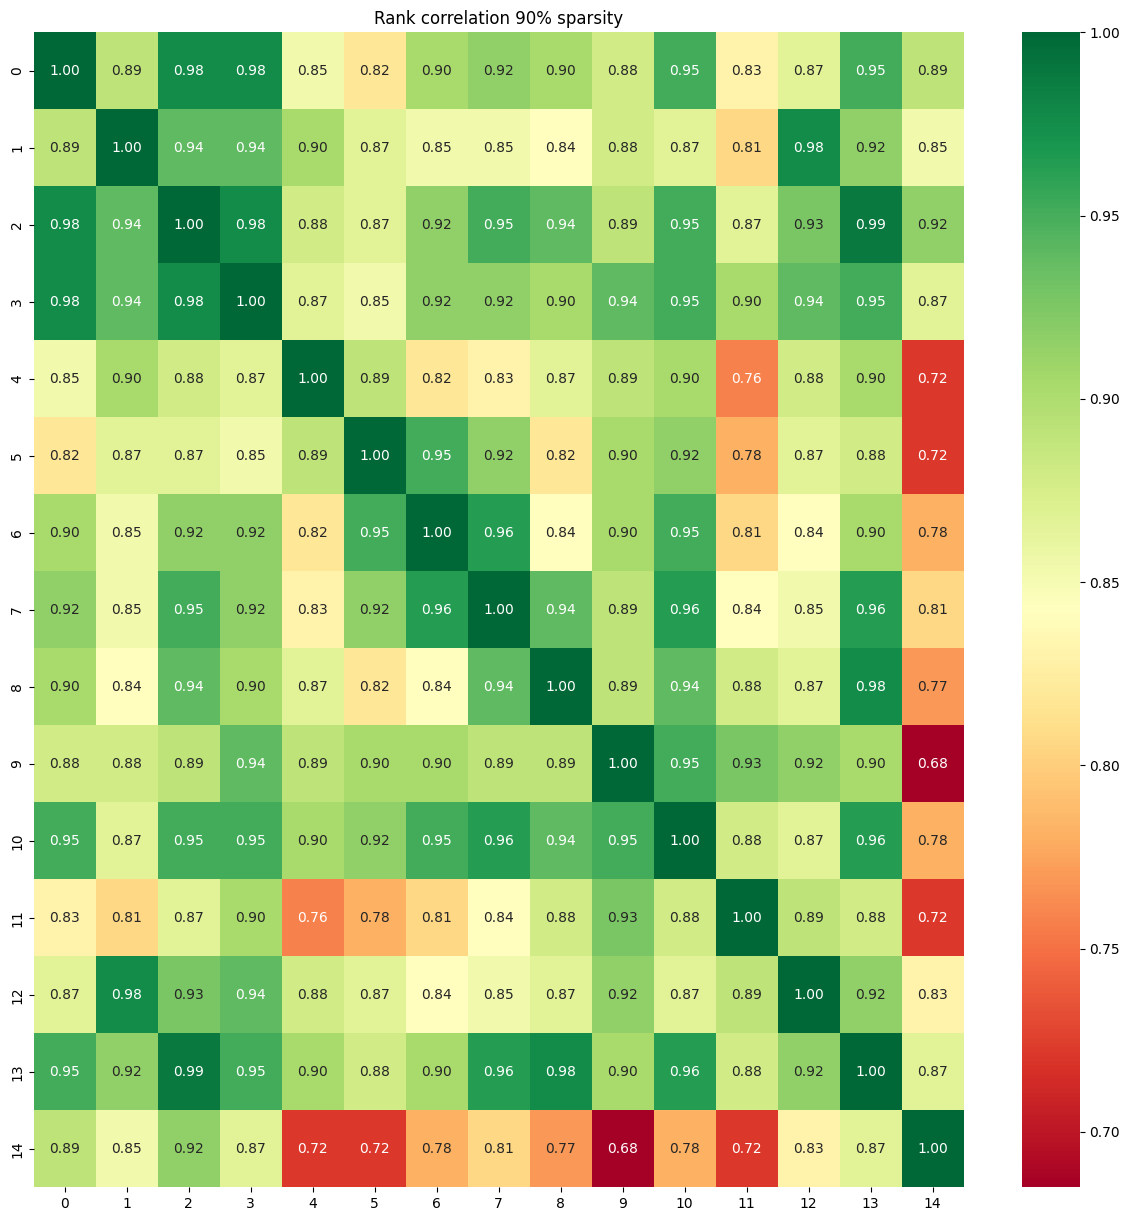

In [14]:
a4_dims = (15, 15)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title('Rank correlation 90% sparsity')
sns.heatmap(sprmat[4], annot=True, fmt='.2f', cmap='RdYlGn',ax = ax)

In [15]:
confmat  = np.zeros((5,15,10,10),dtype = np.int32)

In [16]:
for i in range(0,15,1):
    for j in range(gt.shape[0]):
        if(gt[j]!=frames_5[i][j,-1]):
         confmat[0,i,gt[j],frames_5[i][j,-1]]+=1
for i in range(0,15,1):
    for j in range(gt.shape[0]):
        if(gt[j]!=frames_6[i][j,-1]):
         confmat[1,i,gt[j],frames_6[i][j,-1]]+=1
for i in range(0,15,1):
    for j in range(gt.shape[0]):
        if(gt[j]!=frames_7[i][j,-1]):
         confmat[2,i,gt[j],frames_7[i][j,-1]]+=1
for i in range(0,15,1):
    for j in range(gt.shape[0]):
        if(gt[j]!=frames_8[i][j,-1]):
         confmat[3,i,gt[j],frames_8[i][j,-1]]+=1
for i in range(0,15,1):
    for j in range(gt.shape[0]):
        if(gt[j]!=frames_9[i][j,-1]):
         confmat[4,i,gt[j],frames_9[i][j,-1]]+=1


<Axes: title={'center': ' Mean Disagreement sparsity = 0.5'}>

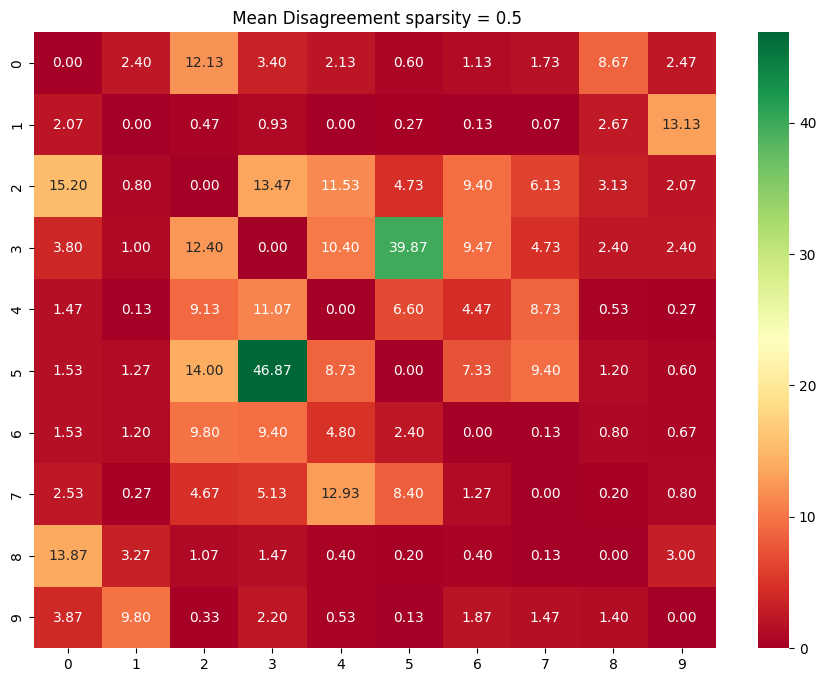

In [56]:

a4_dims = (11, 8)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title(f' Mean Disagreement sparsity = 0.{5}')
sns.heatmap(np.mean(confmat[0],axis = 0), annot=True, fmt='.2f', cmap='RdYlGn',ax = ax)

<Axes: title={'center': ' Mean Disagreement sparsity = 0.6'}>

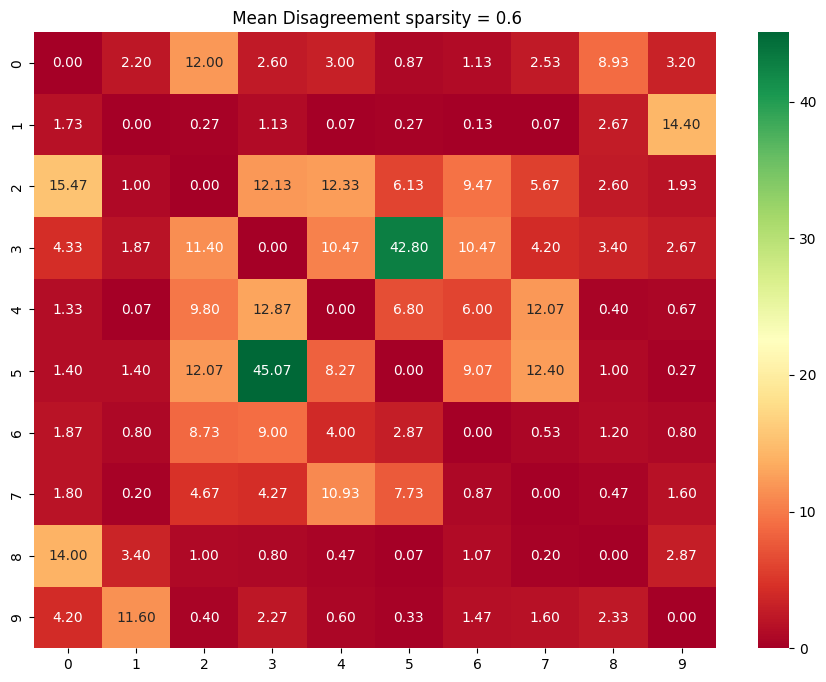

In [57]:
a4_dims = (11, 8)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title(f' Mean Disagreement sparsity = 0.{6}')
sns.heatmap(np.mean(confmat[1],axis = 0), annot=True, fmt='.2f', cmap='RdYlGn',ax = ax)

<Axes: title={'center': ' Mean Disagreement sparsity = 0.7'}>

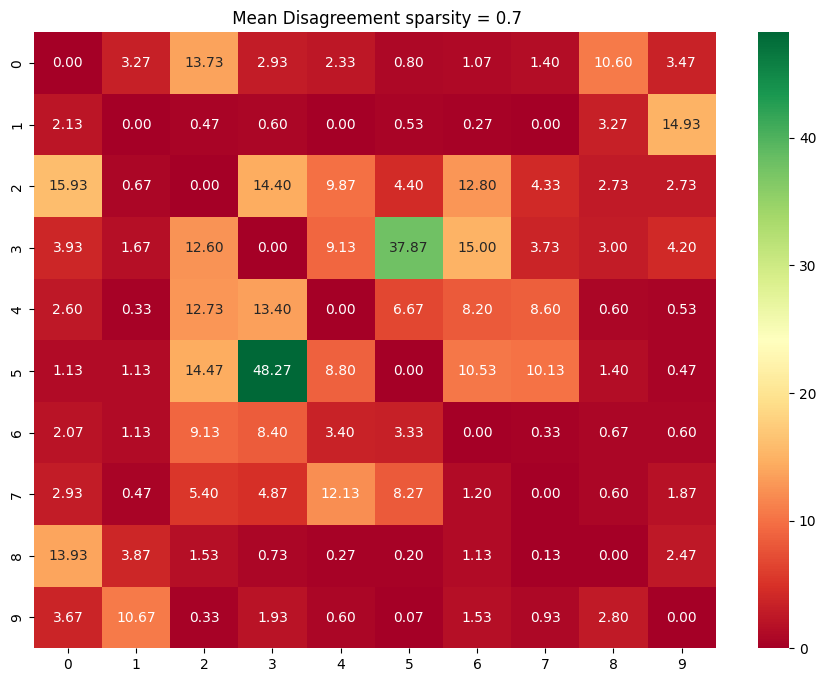

In [58]:
a4_dims = (11, 8)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title(f' Mean Disagreement sparsity = 0.{7}')
sns.heatmap(np.mean(confmat[2],axis = 0), annot=True, fmt='.2f', cmap='RdYlGn',ax = ax)

<Axes: title={'center': ' Mean Disagreement sparsity = 0.8'}>

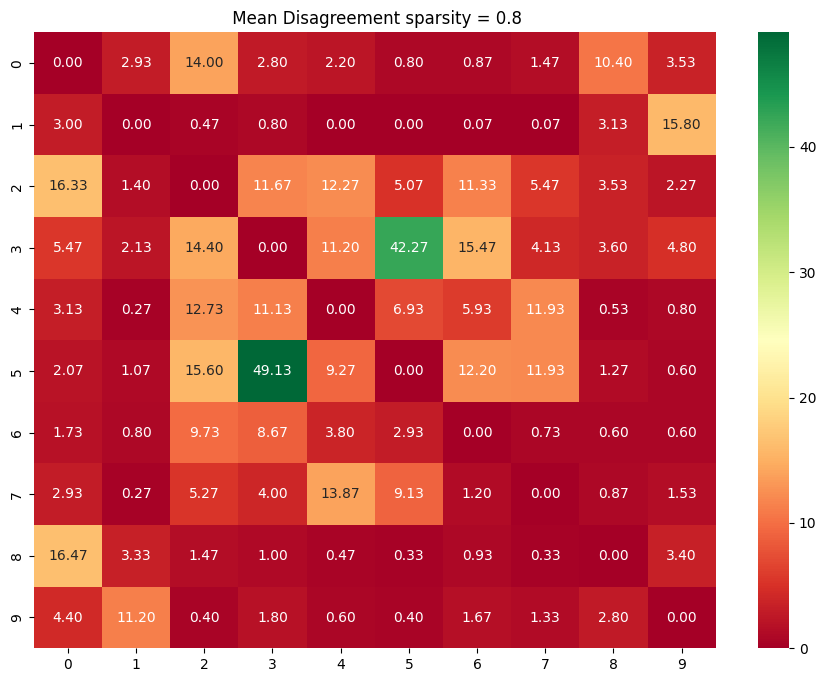

In [59]:
a4_dims = (11, 8)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title(f' Mean Disagreement sparsity = 0.{8}')
sns.heatmap(np.mean(confmat[3],axis = 0), annot=True, fmt='.2f', cmap='RdYlGn',ax = ax)

<Axes: title={'center': ' Mean Disagreement sparsity = 0.9'}>

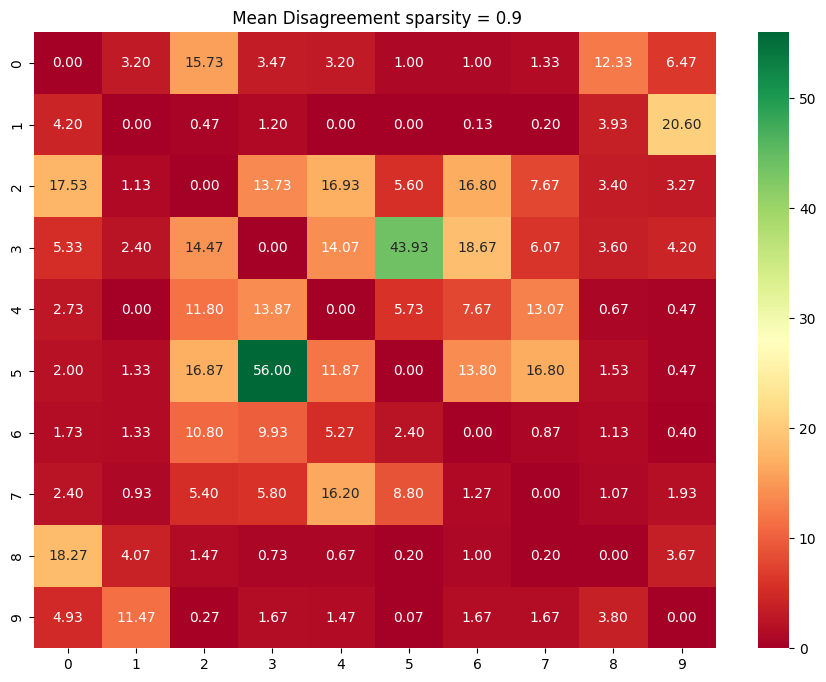

In [60]:
a4_dims = (11, 8)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title(f' Mean Disagreement sparsity = 0.{9}')
sns.heatmap(np.mean(confmat[4],axis = 0), annot=True, fmt='.2f', cmap='RdYlGn',ax = ax)